# Pipeline for High-z Radio Galaxies I: AGN/Galaxy classification

## Introduction

Training for classification of AGN and galaxies will be done in the HETDEX Field.  

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and galaxies from  
spectroscopically detected sources in SDSS DR16 (Spectral Class = "GALAXY").

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
# from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Methdods for PyCaret and saved models.

In [6]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [7]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

***

## Reading data

In [8]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [9]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = False

In [10]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [11]:
mqc_version = '7_4d'  # '7_2'

In [12]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [13]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'Z', 'X_ray_detect', 'radio_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [14]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [15]:
# full_catalog_df.describe()

#### Select only confirmed galaxies and AGN

In [16]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)]

In [17]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
print(f'In this dataset, with {len(full_catalog_df.loc[:, "is_AGN"])} elements,\n' +\
         f'{n_is_AGN} of them are marked as AGN, and {n_is_gal} are identified as galaxies.')

In this dataset, with 85548 elements,
30395 of them are marked as AGN, and 55153 are identified as galaxies.


---

## Possible correlations

In [18]:
print(full_catalog_df.columns.to_list())

['band_num', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag', 'Jmag', 'Hmag', 'Kmag', 'W1mag', 'W2mag', 'W3mag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y', 'g_i', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'FUV_NUV', 'r/z', 'i/y', 'w1/w3', 'w1/w4', 'w2/w4', 'J/K', 'FUV/K', 'g/J', 'r/H', 'i/K', 'z/W1', 'y/W2']


---

## Random seed

In [19]:
seed = 42

Create target

$0$ for galaxies and $1$ for AGN

In [20]:
full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

Remove intermediate targets

In [21]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal'])

## Split data: Test, Train, Validation

In [22]:
train_test_df, validation_df = train_test_split(full_catalog_df, test_size=0.2, random_state=seed, stratify=full_catalog_df.loc[:, 'class'])
# data_train_test_AGN_df = full_catalog_df.sample(frac=0.9, random_state=seed)  # Train + test sets
# data_validation_AGN_df = full_catalog_df.drop(data_train_test_AGN_df.index)  # Validation data

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Unseen Data For Validation: {validation_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (85548, 41)
Data for Modeling (Train and Test): (68438, 41)
Unseen Data For Validation: (17110, 41)
----------------------------------------


---

## Use Correlation matrix to discard some features

In [23]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [24]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [25]:
rsd_vals

z_y         223.394379
i_z         212.574864
class       134.705305
r_i         113.463295
g_r          96.821881
g_i          74.614716
J_H          41.198974
H_K          32.690181
w2_w3        32.352419
band_num     21.866931
w3_w4        17.323289
gmag          7.042670
rmag          6.571578
g/J           6.330722
ymag          6.117134
imag          6.013527
zmag          5.983059
r/H           5.765099
W1mproPM      5.628783
i/K           5.588566
W1mag         5.526000
w1/w4         5.327564
W2mproPM      4.905258
w1/w3         4.780304
W2mag         4.713447
y/W2          4.617226
z/W1          4.596772
w2/w4         4.529881
r/z           3.309234
i/y           2.876422
W3mag         2.722713
NUVmag        2.070940
Hmag          2.035045
Jmag          1.960171
FUV/K         1.443960
W4mag         1.338771
Kmag          1.244955
J/K           1.021024
FUVmag        0.742347
FUV_NUV     -38.870058
w1_w2      -241.357768
dtype: float64

In [26]:
correlation = norm_train_test_df.corr()

In [27]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [28]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [29]:
target_feat = 'class'

In [30]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [31]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [32]:
list_drop_corr

['i/K',
 'w1/w4',
 'g/J',
 'Jmag',
 'w2/w4',
 'r/H',
 'FUV_NUV',
 'W3mag',
 'W2mag',
 'zmag',
 'W2mproPM',
 'Kmag',
 'imag',
 'J/K',
 'w1/w3',
 'Hmag',
 'rmag',
 'W1mag',
 'W1mproPM',
 'g_i']

In [33]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [34]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [35]:
corr_discard = norm_train_test_discard.corr()

In [36]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

band_num  band_num    1.000000
class     w1_w2       0.782290
band_num  ymag        0.738434
r/z       r_i         0.689108
NUVmag    FUVmag      0.686532
band_num  gmag        0.668914
y/W2      z/W1        0.651354
gmag      ymag        0.630444
ymag      y/W2        0.602216
          w2_w3       0.578916
H_K       ymag        0.573200
i/y       z_y         0.572537
          i_z         0.564492
r/z       i_z         0.523345
NUVmag    w3_w4       0.521784
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

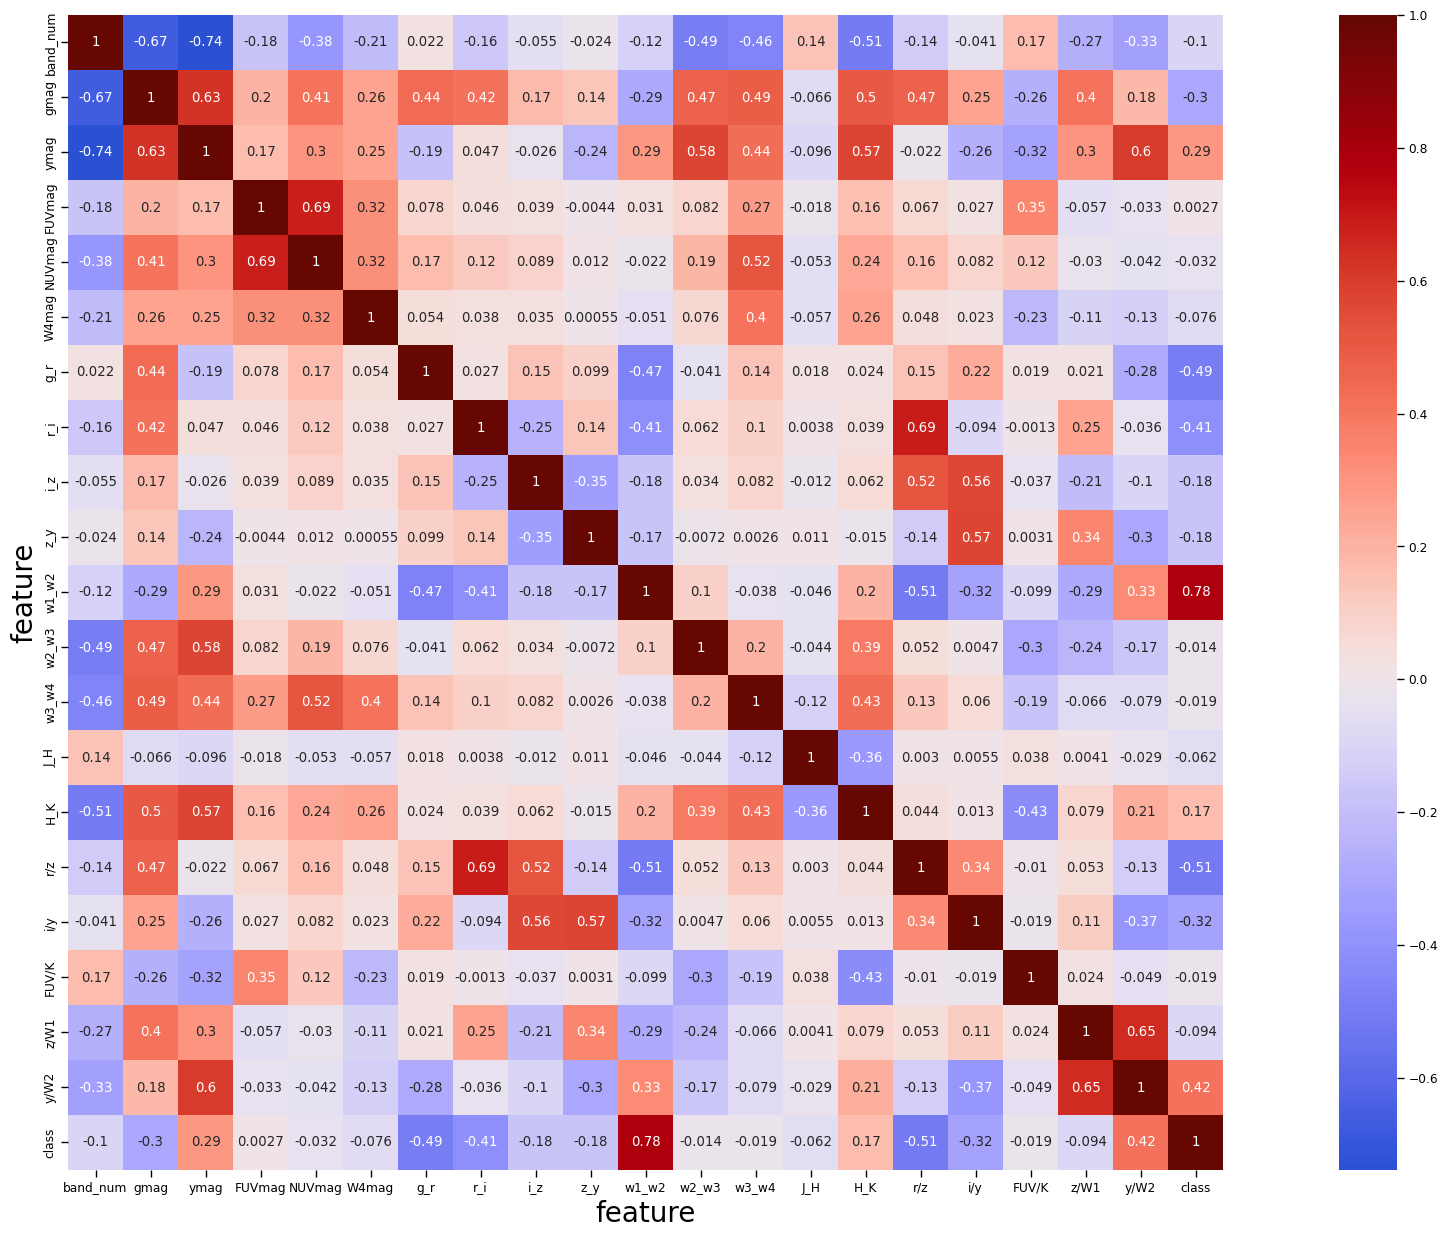

In [37]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [38]:
norm_train_test_discard.loc[:, 'class'] = norm_train_test_discard.loc[:, 'class'].astype(bool)

In [39]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [40]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y     
FUV/K     FUV/K     1.000000
w1_w2     class     0.714168
FUV/K     FUVmag    0.604958
g_r       class     0.552102
NUVmag    FUVmag    0.536125
r/z       class     0.516570
class     w1_w2     0.492046
r_i       class     0.453023
band_num  gmag      0.410168
          ymag      0.375535
J_H       H_K       0.360670
r_i       r/z       0.343060
r/z       r_i       0.307023
band_num  class     0.282483
y/W2      class     0.270876
ymag      H_K       0.253039
class     r/z       0.252503
          g_r       0.248385
i/y       class     0.247245
gmag      class     0.217317
dtype: float64

In [41]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [42]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [43]:
target_feat = 'class'

In [44]:
list_drop_pps = []

In [45]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [46]:
list_drop_pps

[]

In [47]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [48]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'class', random_seed=seed)

In [49]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,w1_w2,class,0.714168,classification,True,weighted F1,0.5544,0.872633,DecisionTreeClassifier()
1,g_r,class,0.552102,classification,True,weighted F1,0.5544,0.800417,DecisionTreeClassifier()
2,r/z,class,0.516570,classification,True,weighted F1,0.5544,0.784584,DecisionTreeClassifier()
3,r_i,class,0.453023,classification,True,weighted F1,0.5544,0.756267,DecisionTreeClassifier()
4,band_num,class,0.282483,classification,True,weighted F1,0.5544,0.680275,DecisionTreeClassifier()
5,y/W2,class,0.270876,classification,True,weighted F1,0.5544,0.675102,DecisionTreeClassifier()
6,i/y,class,0.247245,classification,True,weighted F1,0.5544,0.664572,DecisionTreeClassifier()
7,gmag,class,0.217317,classification,True,weighted F1,0.5544,0.651236,DecisionTreeClassifier()
8,i_z,class,0.176033,classification,True,weighted F1,0.5544,0.632840,DecisionTreeClassifier()
9,ymag,class,0.131645,classification,True,weighted F1,0.5544,0.613061,DecisionTreeClassifier()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [50]:
# final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats = pps_pred_target.x.to_list()  # After Boruta

In [51]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards one feature.

In [52]:
exp_AGN = pyc.setup(data=train_test_df, target='class', session_id=seed, silent=True,\
                    feature_selection=False, feature_selection_method='boruta', data_split_stratify=True,\
                    numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                    transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                    normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,class
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(68438, 41)"
5,Missing Values,False
6,Numeric Features,20
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [53]:
pyc.get_config('X').columns

Index(['band_num', 'gmag', 'ymag', 'FUVmag', 'NUVmag', 'W4mag', 'g_r', 'r_i',
       'i_z', 'z_y', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'r/z', 'i/y',
       'FUV/K', 'z/W1', 'y/W2'],
      dtype='object')

In [54]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [55]:
# used_models_clf      = ['catboost','xgboost', 'lightgbm', 'rf', 'et', 'lr', 'dt', 'svm', 'lda']  # knn too slow, ridge does not work
final_selection_clf  = ['catboost', 'xgboost', 'lightgbm', 'rf', 'et']
n_models             = 5
top_model_AGN = pyc.compare_models(n_select=n_models, include=final_selection_clf, sort='MCC')  # 1:15 hour for used_models_clf
# top_model_AGN = pyc.compare_models(n_select=n_models, sort='MCC')  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9494,0.9842,0.9156,0.9410,0.9281,0.8891,0.8893,1.8280
xgboost,Extreme Gradient Boosting,0.9483,0.9831,0.9118,0.9414,0.9263,0.8864,0.8867,9.3420
lightgbm,Light Gradient Boosting Machine,0.9481,0.9835,0.9132,0.9397,0.9262,0.8863,0.8865,27.9190
rf,Random Forest Classifier,0.9477,0.9816,0.9082,0.9431,0.9253,0.8851,0.8855,0.7740
et,Extra Trees Classifier,0.9474,0.9810,0.9088,0.9418,0.9249,0.8845,0.8848,0.2620
gbc,Gradient Boosting Classifier,0.9447,0.9814,0.9067,0.9363,0.9213,0.8787,0.8790,2.0040
knn,K Neighbors Classifier,0.9416,0.9662,0.9011,0.9330,0.9167,0.8718,0.8721,1.8210
ada,Ada Boost Classifier,0.9412,0.9766,0.9057,0.9278,0.9166,0.8712,0.8714,0.4370
lr,Logistic Regression,0.9354,0.9697,0.9010,0.9164,0.9086,0.8586,0.8588,0.3170
svm,SVM - Linear Kernel,0.9334,0.0000,0.8946,0.9170,0.9055,0.8541,0.8544,0.0380


Results from `compare_models` are with ad-hoc imputation are:  

|            |Model                          |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |TT (Sec)|
|------------|-------------------------------|--------|------|------|------|------|------|------|--------|
|**xgboost** |Extreme Gradient Boosting      |0.9979  |0.9876|0.6146|0.8104|0.6989|0.6979|0.7047|92.2400 |
|**catboost**|CatBoost Classifier            |0.9978  |0.9859|0.6162|0.7928|0.6933|0.6922|0.6978|203.0220|
|**rf**      |Random Forest Classifier       |0.9978  |0.9632|0.5756|0.8353|0.6815|0.6804|0.6924|109.3340|
|**et**      |Extra Trees Classifier         |0.9978  |0.9674|0.5513|0.8511|0.6691|0.6680|0.6840|65.3530 |
|**lightgbm**|Light Gradient Boosting Machine|0.9969  |0.8978|0.5630|0.6439|0.6000|0.5984|0.6002|6.4480  |
|**svm**     |SVM - Linear Kernel            |0.9970  |0.0000|0.4770|0.6796|0.5601|0.5587|0.5677|1.6290  |
|**dt**      |Decision Tree Classifier       |0.9963  |0.7847|0.5713|0.5481|0.5593|0.5575|0.5577|9.7660  |
|**lr**      |Logistic Regression            |0.9970  |0.9778|0.4028|0.7356|0.5205|0.5192|0.5430|5.6770  |
|**lda**     |Linear Discriminant Analysis   |0.9920  |0.9700|0.4343|0.2367|0.3064|0.3027|0.3169|2.3460  |

Thus, we select `xgboost` as meta learner.

Thus, we stack the models.

In [56]:
stacked_model_AGN = pyc.stack_models(estimator_list=top_model_AGN[1:], meta_model=top_model_AGN[0])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9499,0.9854,0.9169,0.9411,0.9289,0.8902,0.8904
1,0.9455,0.9832,0.9111,0.9346,0.9227,0.8806,0.8808
2,0.9499,0.9855,0.9122,0.9454,0.9285,0.8900,0.8903
3,0.9476,0.9812,0.9087,0.9424,0.9252,0.8849,0.8853
4,0.9447,0.9837,0.9052,0.9376,0.9211,0.8785,0.8789
5,0.9522,0.9856,0.9210,0.9436,0.9322,0.8953,0.8954
6,0.9507,0.9855,0.9116,0.9483,0.9296,0.8917,0.8921
7,0.9472,0.9818,0.9075,0.9423,0.9246,0.8840,0.8843
8,0.9528,0.9856,0.9227,0.9437,0.9331,0.8967,0.8968


In [57]:
# tuned_AGN_clf = pyc.tune_model(top_model_AGN, early_stopping='asha', optimize='MCC')  #  minutes
tuned_AGN_clf = pyc.tune_model(stacked_model_AGN, early_stopping='asha', optimize='MCC')  # 20  minutes

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9505,0.9854,0.9187,0.9412,0.9298,0.8916,0.8918
1,0.9443,0.9836,0.9116,0.9307,0.9211,0.8780,0.8781
2,0.9501,0.9858,0.9152,0.9433,0.9290,0.8906,0.8908
3,0.9480,0.9818,0.9105,0.9419,0.9259,0.8859,0.8862
4,0.9447,0.9834,0.9064,0.9365,0.9212,0.8786,0.8789
5,0.9520,0.9853,0.9198,0.9441,0.9318,0.8948,0.8950
6,0.9491,0.9860,0.9070,0.9480,0.9270,0.8879,0.8884
7,0.9478,0.9820,0.9087,0.9429,0.9255,0.8854,0.8857
8,0.9539,0.9863,0.9227,0.9465,0.9345,0.8989,0.8991


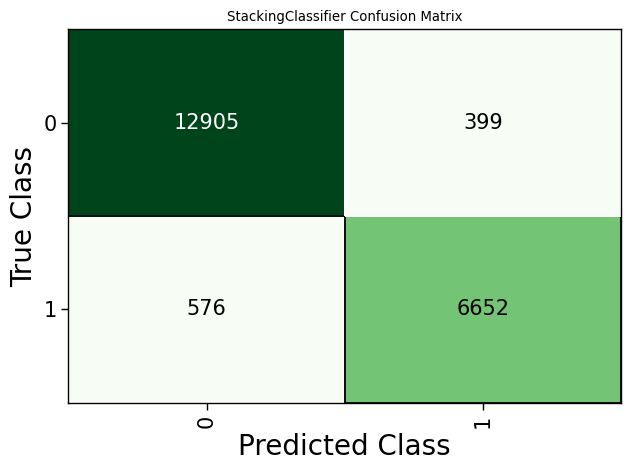

In [58]:
pyc.plot_model(tuned_AGN_clf, plot='confusion_matrix')

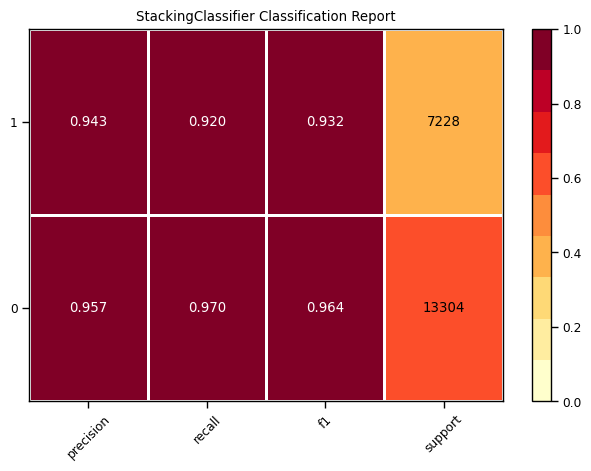

In [59]:
pyc.plot_model(tuned_AGN_clf, plot='class_report')

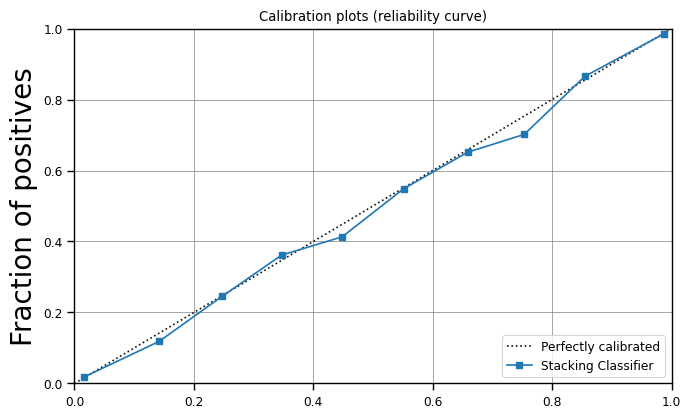

In [62]:
pyc.plot_model(tuned_AGN_clf, plot='calibration')

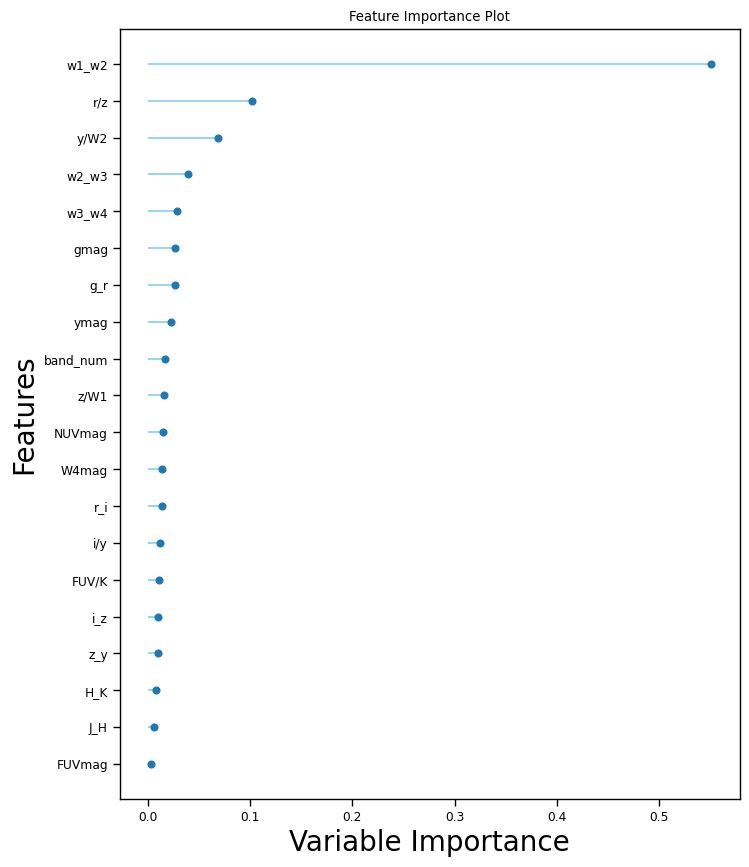

In [67]:
pyc.plot_model(tuned_AGN_clf.estimators_[0], plot='feature_all')

In [68]:
pyc.plot_model(tuned_AGN_clf, plot='parameter')

,Parameters
cv,5
estimators,"[('xgboost', XGBClassifier(base_score=0.5, boo..."
final_estimator,<catboost.core.CatBoostClassifier object at 0x...
n_jobs,12
passthrough,True
stack_method,auto
verbose,0


In [69]:
plt.rcParams.update(plt.rcParamsDefault)

In [70]:
pyc.predict_model(tuned_AGN_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9525,0.9853,0.9203,0.9434,0.9317,0.8953,0.8955


,band_num,gmag,ymag,FUVmag,NUVmag,W4mag,g_r,r_i,i_z,z_y,...,H_K,r/z,i/y,FUV/K,z/W1,y/W2,class,Label,Score_0,Score_1
0,-0.080978,0.431624,0.124853,0.157743,0.356621,0.2046,-0.364254,0.334523,0.127212,1.112809,...,0.338914,0.339290,1.074369,-0.06921,1.016147,-0.048358,0,0,0.9769,0.0231
1,-2.036428,-0.284091,1.586593,0.157743,0.356621,0.2046,-0.391744,-0.466455,-0.850686,-2.171378,...,0.338914,-1.103500,-2.607717,-0.06921,-0.920556,0.755746,1,1,0.2324,0.7676
2,-0.080978,1.385348,0.456647,0.157743,0.356621,0.2046,0.763911,0.731601,0.697627,-0.028994,...,0.338914,1.089493,0.543821,-0.06921,0.365589,0.022650,0,0,0.9871,0.0129
3,-0.080978,0.247599,-0.075095,0.157743,0.356621,0.2046,-0.308530,0.937152,0.388404,-0.001139,...,0.338914,1.132015,0.350262,-0.06921,0.394833,-0.195071,0,0,0.9941,0.0059
4,-0.080978,0.404156,-0.462563,0.157743,0.356621,0.2046,1.408309,0.157803,-0.157636,0.304389,...,0.338914,0.045677,0.164374,-0.06921,-1.730952,-1.687256,0,0,0.9957,0.0043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20527,-0.486399,1.385348,-0.492337,0.157743,0.356621,0.2046,2.954979,0.107872,0.498196,-0.199755,...,0.338914,0.510665,0.302201,-0.06921,-0.253175,-0.410591,0,0,0.9868,0.0132
20528,-1.272575,1.385348,1.586593,0.157743,0.356621,0.2046,0.376151,-2.496103,3.060581,-0.468379,...,0.338914,0.047176,1.810269,-0.06921,0.133080,0.755746,0,0,0.6449,0.3551
20529,-0.080978,-0.785973,0.206710,0.157743,0.356621,0.2046,-0.824779,-0.840505,-0.521040,0.009791,...,0.338914,-1.156614,-0.468415,-0.06921,-0.396648,-0.220891,1,1,0.0072,0.9928
20530,-3.153695,1.385348,1.586593,0.157743,0.356621,0.2046,-0.894806,1.690484,-1.837400,1.314802,...,0.338914,0.044604,-0.559689,-0.06921,0.839712,0.755746,0,0,0.7536,0.2464


In [71]:
test_prediction_clf = pyc.predict_model(tuned_AGN_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9525,0.9853,0.9203,0.9434,0.9317,0.8953,0.8955


Metrics from applying model to test data.  

|Model                    |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |
|-------------------------|--------|------|------|------|------|------|------|
|Extreme Gradient Boosting|0.9978  |0.9781|0.5978|0.8092|0.6876|0.6865|0.6945|

In [72]:
final_AGN_clf = pyc.finalize_model(tuned_AGN_clf)

In [65]:
if save_model_flag:
    if use_5sigma:
        pyc.save_model(final_AGN_clf, '../../models/model_final_HETDEX_AGN_detect_mar_28_2022')  # Model (it will be saved with .pkl extension)
        # pyc.save_config('../../models/config_final_HETDEX_AGN_detect_mar_28_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['Hmag', 'Kmag', 'W2mag',
                                                        'zmag', 'rmag', 'Jmag',
                                                        'W2mproPM', 'w1/w3',
                                                        'i/K', 'NUVmag', 'ymag',
                                                        'J/K', 'w2/w4', 'W1mag',
                                                        'gmag', 'W4mag', 'imag',
                                                        'g/J', 'W1mproPM',
                                                        'y/W2', 'J_H', 'z_y',
                                                        'W3mag'],
                                       id_columns=[],
                                       ml_usecase='classification',
   

## Load Models

AGN detection model.

In [49]:
if load_model_flag:
    if use_5sigma:
        final_AGN_clf = pyc.load_model('../../models/model_final_HETDEX_AGN_detect_mar_28_2022')

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [78]:
extended_data_AGN = validation_df.loc[:, get_final_column_names(final_AGN_clf, validation_df)].copy()
extended_idx_AGN  = extended_data_AGN.index
initial_cols_AGN  = extended_data_AGN.columns
extended_cols_AGN = extended_data_AGN.columns.insert(0, 'xgboost')
extended_cols_AGN = extended_cols_AGN.insert(0, 'lightgbm')
extended_cols_AGN = extended_cols_AGN.insert(0, 'rf')
extended_cols_AGN = extended_cols_AGN.insert(0, 'et')

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [82]:
print('Running data pre-processing:\n')
if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
    prep_steps = final_AGN_clf.named_steps.items()
else:
    prep_steps = pyc.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_AGN = method.transform(extended_data_AGN)
extended_data_AGN_df = pd.DataFrame(extended_data_AGN, columns=extended_cols_AGN, index=extended_idx_AGN)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [85]:
if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
    importances_coef = final_AGN_clf.named_steps['trained_model'].final_estimator_.feature_importances_
else:
    importances_coef = final_AGN_clf.final_estimator_.feature_importances_

coef_meta_df = pd.DataFrame({'Feature': extended_cols_AGN, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_AGN))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [89]:
if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
    estimators_list  = ffinal_AGN_clf.named_steps['trained_model'].estimators
    estimators_list_ = ffinal_AGN_clf.named_steps['trained_model'].estimators_
else:
    estimators_list  = final_AGN_clf.estimators
    estimators_list_ = final_AGN_clf.estimators_

In [87]:
base_models_names = [model[0] for model in estimators_list]

In [88]:
coef_sorted_base_df = {}

In [90]:
for model, model_fit in zip(base_models_names, estimators_list_):
    coef_base_df = pd.DataFrame({'Feature': extended_cols_AGN.drop(base_models_names),
                                 'Importance': model_fit.feature_importances_})
    coef_sorted_base_df[model] = (
    coef_base_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_AGN.drop(base_models_names)))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [91]:
print('Feature importances scaled in [1,100]')
coef_sorted_base_df_copy = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy.keys():
    print(key)
    coef_sorted_base_df_copy[key].loc[:, 'Importance'] = (coef_sorted_base_df[key].loc[:, 'Importance'] -\
                                                     coef_sorted_base_df[key].loc[:, 'Importance'].min()) /\
                                                    (coef_sorted_base_df[key].loc[:, 'Importance'].max() -\
                                                     coef_sorted_base_df[key].loc[:, 'Importance'].min()) * (100 - 1) + 1
    display(coef_sorted_base_df_copy[key])

Feature importances scaled in [1,100]
xgboost


,Feature,Importance
0,w1_w2,100.000000
1,r/z,18.366722
2,y/W2,11.190228
3,w2_w3,7.557085
4,w3_w4,5.331078
5,g_r,4.892928
6,ymag,4.525442
7,gmag,4.488737
8,band_num,3.181599
9,z/W1,2.955588


lightgbm


,Feature,Importance
0,w1_w2,100.000000
1,w2_w3,87.625000
2,g_r,86.115854
3,r/z,70.722561
4,gmag,66.195122
5,z/W1,62.875000
6,ymag,60.460366
7,r_i,56.536585
8,y/W2,51.405488
9,i/y,48.990854


rf


,Feature,Importance
0,w1_w2,100.000000
1,r/z,47.615614
2,r_i,38.811015
3,g_r,38.431200
4,y/W2,23.321809
5,gmag,17.612739
6,i/y,15.737771
7,z/W1,11.398945
8,ymag,11.337331
9,w2_w3,10.999814


et


,Feature,Importance
0,w1_w2,100.000000
1,gmag,31.674562
2,r/z,25.431794
3,g_r,23.597311
4,ymag,21.504134
5,y/W2,19.554655
6,r_i,19.045572
7,band_num,12.411336
8,z/W1,12.158397
9,i/y,11.377536


In [92]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(key)
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    display(coef_sorted_base_df_copy_sum[key])

Feature importances scaled to sum 100
xgboost


,Feature,Importance
0,w1_w2,54.908936
1,r/z,10.084972
2,y/W2,6.144435
3,w2_w3,4.149515
4,w3_w4,2.927238
5,g_r,2.686655
6,ymag,2.484872
7,gmag,2.464718
8,band_num,1.746982
9,z/W1,1.622882


lightgbm


,Feature,Importance
0,w1_w2,10.876053
1,w2_w3,9.530141
2,g_r,9.366006
3,r/z,7.691823
4,gmag,7.199416
5,z/W1,6.838318
6,ymag,6.575701
7,r_i,6.148949
8,y/W2,5.590888
9,i/y,5.328271


rf


,Feature,Importance
0,w1_w2,27.967689
1,r/z,13.316987
2,r_i,10.854544
3,g_r,10.748319
4,y/W2,6.522571
5,gmag,4.925876
6,i/y,4.401491
7,z/W1,3.188022
8,ymag,3.170789
9,w2_w3,3.076394


et


,Feature,Importance
0,w1_w2,31.291262
1,gmag,9.911370
2,r/z,7.957929
3,g_r,7.383896
4,ymag,6.728915
5,y/W2,6.118898
6,r_i,5.959600
7,band_num,3.883664
8,z/W1,3.804516
9,i/y,3.560174


In [93]:
print('Feature importances scaled in [1,100]')
coef_sorted_meta_df_copy = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy.loc[:, 'Importance'] = (coef_sorted_meta_df.loc[:, 'Importance'] -\
                                                 coef_sorted_meta_df.loc[:, 'Importance'].min()) /\
                                                (coef_sorted_meta_df.loc[:, 'Importance'].max() -\
                                                 coef_sorted_meta_df.loc[:, 'Importance'].min()) * (100 - 1) + 1
print('Meta model')
display(coef_sorted_meta_df_copy)

Feature importances scaled in [1,100]
Meta model


,Feature,Importance
0,et,100.000000
1,rf,95.444324
2,lightgbm,47.582611
3,xgboost,47.407139
4,gmag,10.652420
5,w2_w3,9.665109
6,w1_w2,5.858906
7,band_num,5.398159
8,ymag,5.285183
9,g_r,5.040503


In [94]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,et,28.531584
1,rf,27.223599
2,lightgbm,13.481975
3,xgboost,13.431595
4,gmag,2.878910
5,w2_w3,2.595442
6,w1_w2,1.502640
7,band_num,1.370354
8,ymag,1.337917
9,g_r,1.267667


Feature importances scaled in [1,100]
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
w1_w2	100.000
w2_w3	87.351
g_r	85.879
r/z	70.572
gmag	66.017
z/W1	62.682
ymag	60.287
r_i	56.396
y/W2	51.284
i/y	48.848
i_z	48.840
w3_w4	42.520
band_num	35.610
z_y	33.796
NUVmag	17.849
H_K	14.541
W4mag	12.135
FUV/K	11.228
J_H	10.327
FUVmag	1.000


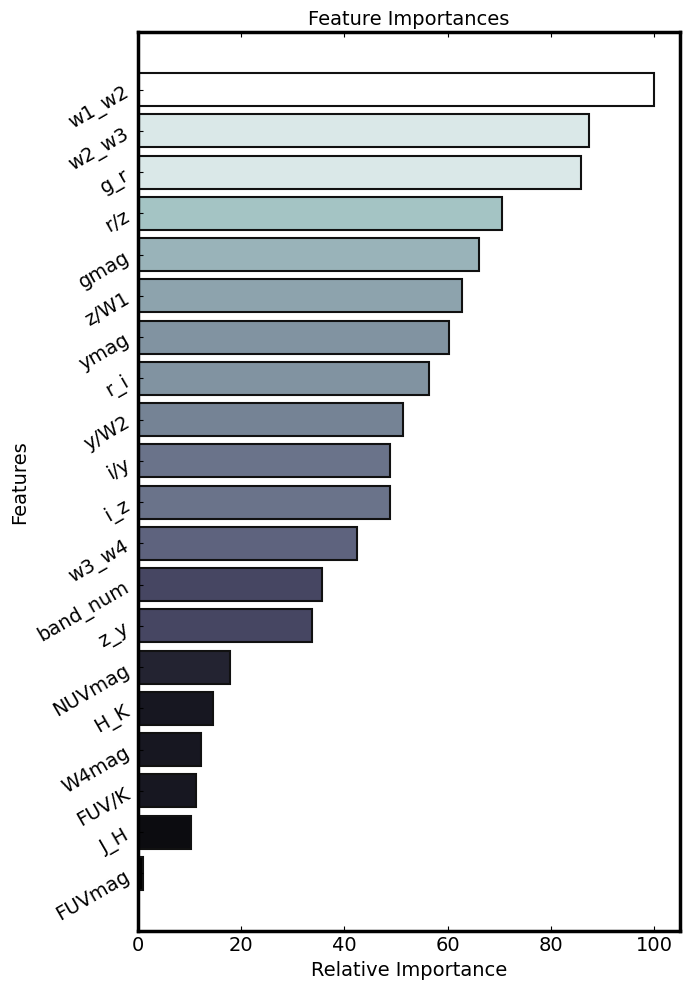

In [97]:
print('Feature importances scaled in [1,100]')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_AGN_clf, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal  * (100 - 1) + 1,\
             color=plt.get_cmap('bone', len(importances))(import_scal), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('../plots/feat_importance_AGN_HETDEX.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * (100 - 1) + 1)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
w1_w2	10.994
w2_w3	9.594
g_r	9.431
r/z	7.736
gmag	7.232
z/W1	6.863
ymag	6.597
r_i	6.167
y/W2	5.601
i/y	5.331
i_z	5.330
w3_w4	4.630
band_num	3.865
z_y	3.665
NUVmag	1.899
H_K	1.533
W4mag	1.266
FUV/K	1.166
J_H	1.066
FUVmag	0.034


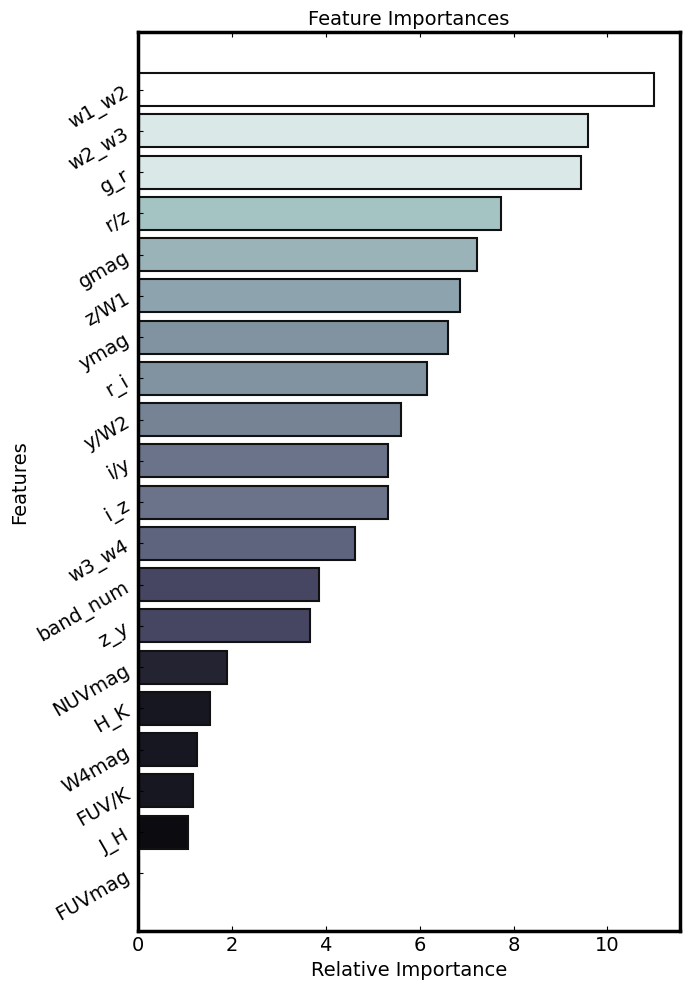

In [98]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_AGN_clf, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('../plots/feat_importance_AGN_HETDEX_perc.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

In [99]:
AGN_pred_threshold = 0.5
# AGN_pred_threshold = 0.49999523  # from MCC optimisation - From S82 data

In [100]:
validation_prediction_clf = pyc.predict_model(final_AGN_clf, data=validation_df, probability_threshold=AGN_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9494,0.9847,0.9128,0.9431,0.9277,0.8888,0.8891


Create confusion matrix with validation data.

In [101]:
cm_mat_val = np.array([[np.sum(np.array(validation_prediction_clf['class'] == 0) & np.array(validation_prediction_clf['Label'] == 0)),\
          np.sum(np.array(validation_prediction_clf['class'] == 0) & np.array(validation_prediction_clf['Label'] ==1))],\
        [np.sum(np.array(validation_prediction_clf['class'] == 1) & np.array(validation_prediction_clf['Label'] == 0)),\
          np.sum(np.array(validation_prediction_clf['class'] == 1) & np.array(validation_prediction_clf['Label'] ==1))]])

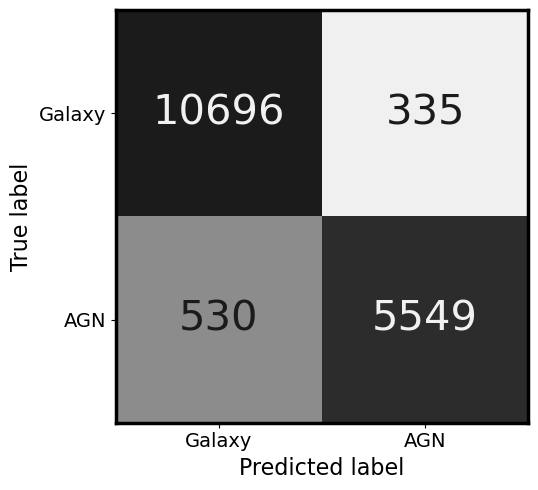

In [102]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat_val,
                              display_labels=['Galaxy', 'AGN'])
norm = ImageNormalize(stretch=LogStretch())

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp_b = disp.plot(include_values=True,
                 cmap=cm.get_cmap('cet_dimgray_r'), ax=ax1, xticks_rotation='horizontal')

for text_val in disp_b.text_.flatten():
    text_val.set_fontsize(30)
clb = plt.gca().images[-1].colorbar
clb.ax.tick_params(labelsize=14)
clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Sources in bin', size=14, path_effects=pe2)
clb.remove()

disp_b.im_.norm = norm

ax1.xaxis.get_label().set_fontsize(16)
ax1.yaxis.get_label().set_fontsize(16)

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('../plots/confusion_matrix_validation_AGN_HETDEX.pdf', bbox_inches='tight')
plt.show()

In [103]:
TN_AGN, FP_AGN, FN_AGN, TP_AGN = cm_mat_val.flatten().astype('float32')

In [104]:
MCC_AGN_val = ((TP_AGN * TN_AGN) - (FP_AGN * FN_AGN)) /\
            np.sqrt((TP_AGN + FP_AGN) * (TP_AGN + FN_AGN) * (TN_AGN + FP_AGN) * (TN_AGN + FN_AGN))

ACC_AGN_val = (TP_AGN + TN_AGN) / (TP_AGN + TN_AGN + FP_AGN + FN_AGN)

F1_AGN_val  = 2 * TP_AGN / (2 * TP_AGN + FP_AGN + FN_AGN)

Recall_AGN_val = TP_AGN / (TP_AGN + FN_AGN)

In [105]:
print('Metrics for Validation set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_val:.4f}')
print(f'Accuracy is ACC = {ACC_AGN_val:.4f}')
print(f'F1-score is F1 = {F1_AGN_val:.4f}')
print(f'Recall is TPR = {Recall_AGN_val:.4f}')

Metrics for Validation set.
Matthews Correlation Coefficient is MCC = 0.8891
Accuracy is ACC = 0.9494
F1-score is F1 = 0.9277
Recall is TPR = 0.9128


In [106]:
train_size         = 0.7
data_split_shuffle = True
_stratify_columns = _get_columns_to_stratify_by(
            train_test_df.drop(columns=['class']), train_test_df.loc[:, 'class'], False, 'class'
        )

X_train, X_test, y_train, y_test = train_test_split(
                train_test_df.drop(columns=['class']),
                train_test_df.loc[:, 'class'],
                test_size=1 - train_size,
                stratify=_stratify_columns,
                random_state=seed,
                shuffle=data_split_shuffle,
            )
train_data_df        = pd.concat([X_train, y_train], axis=1)
test_data_df         = pd.concat([X_test, y_test], axis=1)

In [107]:
train_prediction_clf = pyc.predict_model(final_AGN_clf, data=train_data_df, probability_threshold=AGN_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9796,0.9990,0.9576,0.9847,0.9710,0.9552,0.9554


In [108]:
test_prediction_clf = pyc.predict_model(final_AGN_clf, data=test_data_df, probability_threshold=AGN_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9801,0.9991,0.9563,0.9869,0.9713,0.9561,0.9564


In [111]:
cm_mat_train = np.array([[np.sum(np.array(train_prediction_clf['class'] == 0) & np.array(train_prediction_clf['Label'] == 0)),\
          np.sum(np.array(train_prediction_clf['class'] == 0) & np.array(train_prediction_clf['Label'] ==1))],\
        [np.sum(np.array(train_prediction_clf['class'] == 1) & np.array(train_prediction_clf['Label'] == 0)),\
          np.sum(np.array(train_prediction_clf['class'] == 1) & np.array(train_prediction_clf['Label'] ==1))]])

In [109]:
cm_mat_test = np.array([[np.sum(np.array(test_prediction_clf['class'] == 0) & np.array(test_prediction_clf['Label'] == 0)),\
          np.sum(np.array(test_prediction_clf['class'] == 0) & np.array(test_prediction_clf['Label'] ==1))],\
        [np.sum(np.array(test_prediction_clf['class'] == 1) & np.array(test_prediction_clf['Label'] == 0)),\
          np.sum(np.array(test_prediction_clf['class'] == 1) & np.array(test_prediction_clf['Label'] ==1))]])

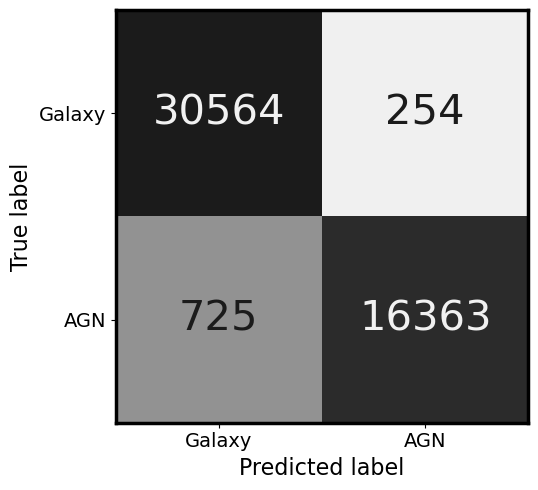

In [112]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat_train,
                              display_labels=['Galaxy', 'AGN'])
norm = ImageNormalize(stretch=LogStretch())

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp_b = disp.plot(include_values=True,
                 cmap=cm.get_cmap('cet_dimgray_r'), ax=ax1, xticks_rotation='horizontal')

for text_val in disp_b.text_.flatten():
    text_val.set_fontsize(30)
clb = plt.gca().images[-1].colorbar
clb.ax.tick_params(labelsize=14)
clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Sources in bin', size=14, path_effects=pe2)
clb.remove()

disp_b.im_.norm = norm

ax1.xaxis.get_label().set_fontsize(16)
ax1.yaxis.get_label().set_fontsize(16)

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('../plots/confusion_matrix_train_AGN_HETDEX.pdf', bbox_inches='tight')
plt.show()

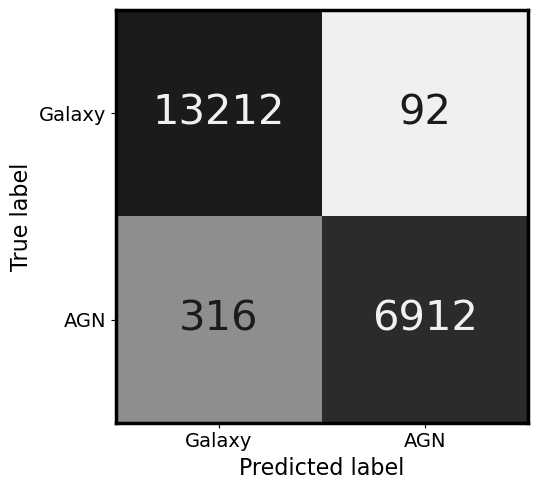

In [113]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat_test,
                              display_labels=['Galaxy', 'AGN'])
norm = ImageNormalize(stretch=LogStretch())

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp_b = disp.plot(include_values=True,
                 cmap=cm.get_cmap('cet_dimgray_r'), ax=ax1, xticks_rotation='horizontal')

for text_val in disp_b.text_.flatten():
    text_val.set_fontsize(30)
clb = plt.gca().images[-1].colorbar
clb.ax.tick_params(labelsize=14)
clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Sources in bin', size=14, path_effects=pe2)
clb.remove()

disp_b.im_.norm = norm

ax1.xaxis.get_label().set_fontsize(16)
ax1.yaxis.get_label().set_fontsize(16)

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('../plots/confusion_matrix_test_AGN_HETDEX.pdf', bbox_inches='tight')
plt.show()

In [114]:
TN_AGN_train, FP_AGN_train, FN_AGN_train, TP_AGN_train = cm_mat_train.flatten().astype('float32')

In [115]:
MCC_AGN_train = ((TP_AGN_train * TN_AGN_train) - (FP_AGN_train * FN_AGN_train)) /\
            np.sqrt((TP_AGN_train + FP_AGN_train) * (TP_AGN_train + FN_AGN_train) * 
                    (TN_AGN_train + FP_AGN_train) * (TN_AGN_train + FN_AGN_train))

ACC_AGN_train = (TP_AGN_train + TN_AGN_train) / (TP_AGN_train + TN_AGN_train + FP_AGN_train + FN_AGN_train)

F1_AGN_train  = 2 * TP_AGN_train / (2 * TP_AGN_train + FP_AGN_train + FN_AGN_train)

Recall_AGN_train = TP_AGN_train / (TP_AGN_train + FN_AGN_train)

In [116]:
print('Metrics for Training set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_train:.4f}')
print(f'Accuracy is ACC = {ACC_AGN_train:.4f}')
print(f'F1-score is F1 = {F1_AGN_train:.4f}')
print(f'Recall is TPR = {Recall_AGN_train:.4f}')

Metrics for Training set.
Matthews Correlation Coefficient is MCC = 0.9554
Accuracy is ACC = 0.9796
F1-score is F1 = 0.9710
Recall is TPR = 0.9576


In [117]:
TN_AGN_test, FP_AGN_test, FN_AGN_test, TP_AGN_test = cm_mat_test.flatten().astype('float32')

In [118]:
MCC_AGN_test = ((TP_AGN_test * TN_AGN_test) - (FP_AGN_test * FN_AGN_test)) /\
            np.sqrt((TP_AGN_test + FP_AGN_test) * (TP_AGN_test + FN_AGN_test) * 
                    (TN_AGN_test + FP_AGN_test) * (TN_AGN_test + FN_AGN_test))

ACC_AGN_test = (TP_AGN_test + TN_AGN_test) / (TP_AGN_test + TN_AGN_test + FP_AGN_test + FN_AGN_test)

F1_AGN_test  = 2 * TP_AGN_test / (2 * TP_AGN_test + FP_AGN_test + FN_AGN_test)

Recall_AGN_test = TP_AGN_test / (TP_AGN_test + FN_AGN_test)

In [119]:
print('Metrics for Test set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_test:.4f}')
print(f'Accuracy is ACC = {ACC_AGN_test:.4f}')
print(f'F1-score is F1 = {F1_AGN_test:.4f}')
print(f'Recall is TPR = {Recall_AGN_test:.4f}')

Metrics for Test set.
Matthews Correlation Coefficient is MCC = 0.9564
Accuracy is ACC = 0.9801
F1-score is F1 = 0.9713
Recall is TPR = 0.9563
